In [119]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os 
from scipy.stats import binom_test
from sequencing_tools.stats_tools import p_adjust
from scipy.stats import beta
from scipy.special import betaln
from functools import partial
from repeats_utils import *
from plotting_utils import spring_layout
import adjustText
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
count_table = '/stor/work/Lambowitz/cdw2854/cell_Free_nucleotides/tgirt_map/Counts/all_counts/spreaded_all_counts.tsv'
df = pd.read_table(count_table)
df.head()

,gene_id,gene_name,gene_type,grouped_type,IGG-cf_R1_001:all:antisense,IGG-cf_R1_001:all:sense,IGG-cf_R1_001:dedup:antisense,IGG-cf_R1_001:dedup:sense,QCF1_R1_001:all:antisense,QCF1_R1_001:all:sense,...,S96-cfD_R1_001:dedup:antisense,S96-cfD_R1_001:dedup:sense,S96-cf_R1_001:all:antisense,S96-cf_R1_001:all:sense,S96-cf_R1_001:dedup:antisense,S96-cf_R1_001:dedup:sense,genome-sim_R1_001:all:antisense,genome-sim_R1_001:all:sense,genome-sim_R1_001:dedup:antisense,genome-sim_R1_001:dedup:sense
0,.,.,No features,No features,0,0,0,0,1164939,69311,...,0,0,0,0,0,0,26647609,26664118,26647609,26664118
1,.,.,tRNA,tRNA,0,0,0,0,10237961,0,...,0,0,0,0,0,0,568,0,568,0
2,.,No features:.,Repeats,Repeats,3745,4542,2989,3742,35812,17223,...,94446,92684,159513,155574,101781,100419,16867723,16876133,16867723,16876133
3,18S_rRNA,18S_rRNA,rDNA,rRNA,0,0,0,0,734,175520,...,0,0,0,0,0,0,225,252,225,252
4,28S_rRNA,28S_rRNA,rDNA,rRNA,0,0,0,0,1089,384807,...,0,0,0,0,0,0,506,533,506,533


(4.1862092074902755, 4.188272589654578, 0, 1)


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


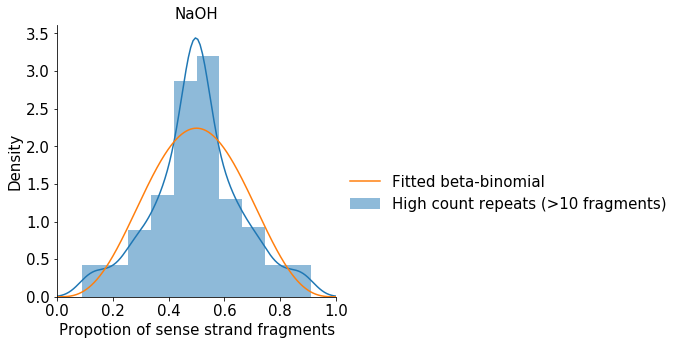

In [107]:
fig = plt.figure(figsize=(5,5))
#ax = fig.add_subplot(121)
sample_regex = 'Q[cC][fF][0-9]+'
#sample_regex = '[aA][lL][lL]'
p_df = get_repeat_df(df, sample_regex = sample_regex)
#alpha0, beta0 = model_df(p_df, ax, title = 'DNase-I')
#ax.legend().set_visible(False)

ax = fig.add_subplot(111)
sample_regex = '[Nn][aA]'
naoh_p_df = get_repeat_df(df, sample_regex = sample_regex)
naoh_alpha0, naoh_beta0 = model_df(naoh_p_df, ax, title= 'NaOH')
ax.legend(bbox_to_anchor = (1,0.5), fontsize=15, frameon=False)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


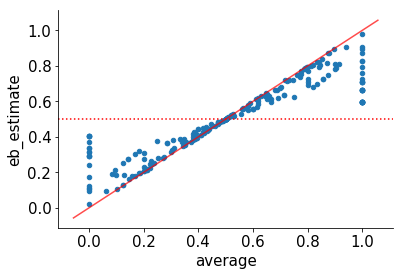

In [108]:
dnase_posterior_df = update_empirical_bayesr(p_df, naoh_alpha0, naoh_beta0)
naoh_posterior_df = update_empirical_bayesr(naoh_p_df, naoh_alpha0, naoh_beta0)


ax = plt.subplot()
dnase_posterior_df.plot.scatter('average','eb_estimate', ax = ax)
plt.axhline(naoh_alpha0/(naoh_alpha0+naoh_beta0), color='r', linestyle=':')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()])
]
plt.plot(lims, lims, 'r-', alpha=.7)
sns.despine()

In [109]:
posterior_df = pd.concat([dnase_posterior_df.assign(treatment = 'DNase'),
         naoh_posterior_df.assign(treatment='NaOH')]) \
    .pipe(pd.melt, id_vars = ['treatment','gene_name','gene_id']) \
    .assign(variable = lambda d: d.treatment + ': ' + d.variable) \
    .pipe(pd.pivot_table, index=['gene_name', 'gene_id'],
         columns = 'variable', values = 'value') \
    .pipe(lambda d: fill_prior(d, (naoh_alpha0, naoh_beta0)))\
    .reset_index() \
    .fillna(0)\
    .pipe(lambda d: calulate_probability(d))  \
    .assign(delta_sense = lambda d: d['DNase: eb_estimate'] - d['NaOH: eb_estimate'])
posterior_df.sort_values('bayes_factor', ascending=False).head()

variable,gene_name,gene_id,DNase: alpha1,DNase: antisense,DNase: average,DNase: beta1,DNase: eb_estimate,DNase: sense,NaOH: alpha1,NaOH: antisense,NaOH: average,NaOH: beta1,NaOH: eb_estimate,NaOH: sense,h0_p,h_p,bayes_factor,pval,qval,delta_sense
167,Simple_repeats:(CGGA)n,Simple_repeats,4.186209,186.0,0.000000,190.188273,0.021537,0.0,37.186209,55.0,0.375000,59.188273,0.385851,33.0,1.145691e-20,5.853450e-02,1.000000e+12,1.000000e+00,1.566035e+02,-0.364314
274,Simple_repeats:(TCTCTG)n,Simple_repeats,189.186209,32.0,0.852535,36.188273,0.839430,185.0,1100.186209,988.0,0.525912,992.188273,0.525808,1096.0,7.331832e-61,2.561268e-40,1.000000e+12,1.178805e-23,1.554018e-23,0.313623
166,Simple_repeats:(CGG)n,Simple_repeats,752.186209,105.0,0.876905,109.188273,0.873239,748.0,424.186209,673.0,0.384263,677.188273,0.385143,420.0,2.363857e-253,4.419580e-139,1.000000e+12,2.723992e-195,2.723992e-195,0.488097
251,Simple_repeats:(TAGA)n,Simple_repeats,156.186209,279.0,0.352668,283.188273,0.355474,152.0,4277.186209,3100.0,0.579547,3104.188273,0.579457,4273.0,1.245612e-140,2.260886e-122,1.000000e+12,1.000000e+00,1.466035e+02,-0.223983
272,Simple_repeats:(TCTCCC)n,Simple_repeats,444.186209,126.0,0.777385,130.188273,0.773339,440.0,1570.186209,159.0,0.907826,163.188273,0.905855,1566.0,1.092772e-143,3.297957e-131,1.000000e+12,1.000000e+00,1.496035e+02,-0.132516


In [110]:
posterior_df[(posterior_df['DNase: eb_estimate'] > 0.5) & \
             (posterior_df.bayes_factor > 1e10) & \
             (posterior_df['DNase: eb_estimate'] < 0.6)]

variable,gene_name,gene_id,DNase: alpha1,DNase: antisense,DNase: average,DNase: beta1,DNase: eb_estimate,DNase: sense,NaOH: alpha1,NaOH: antisense,NaOH: average,NaOH: beta1,NaOH: eb_estimate,NaOH: sense,h0_p,h_p,bayes_factor,pval,qval,delta_sense
262,Simple_repeats:(TCCA)n,Simple_repeats,531.186209,488.0,0.519212,492.188273,0.519054,527.0,2324.186209,3962.0,0.369309,3966.188273,0.369483,2320.0,1.976263e-323,4.269218e-306,1.000000e+12,1.213862e-22,1.369263e-22,0.149571


In [111]:
plot_bf_df \
    .query('bayes_factor > 2')\
    .pipe(lambda d: d[d.gene_id.str.contains('telo|cen')])

variable,gene_name,gene_id,DNase: alpha1,DNase: antisense,DNase: average,DNase: beta1,DNase: eb_estimate,DNase: sense,NaOH: alpha1,NaOH: antisense,...,NaOH: sense,h0_p,h_p,bayes_factor,pval,qval,delta_sense,log_bf,label,color
17,Satellite:REP522,telo,64.186209,28.0,0.681818,32.188273,0.666008,60.0,968.186209,998.0,...,964.0,2.359438e-27,8.804310e-25,373.152850,0.000257,0.001015,0.174637,2.571887,Sense,red
10,Satellite:HSAT4,centr,51.186209,25.0,0.652778,29.188273,0.636847,47.0,1222.186209,1384.0,...,1218.0,5.073380e-23,4.596465e-21,90.599671,0.001149,0.004220,0.168643,1.957127,Sense,red
23,Satellite:TAR1,telo,20.186209,4.0,0.800000,8.188273,0.711421,16.0,818.186209,895.0,...,814.0,5.521561e-07,2.796377e-05,50.644674,0.005079,0.029148,0.235004,1.704534,Sense,red
8,Satellite:GSATII,centr,48.186209,70.0,0.385965,74.188273,0.393760,44.0,1964.186209,1632.0,...,1960.0,3.277867e-36,6.849941e-34,208.975587,0.999629,123.604042,-0.151790,2.320096,Antisense,gray


Text(0.5,0,'$\\Delta$Sense')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


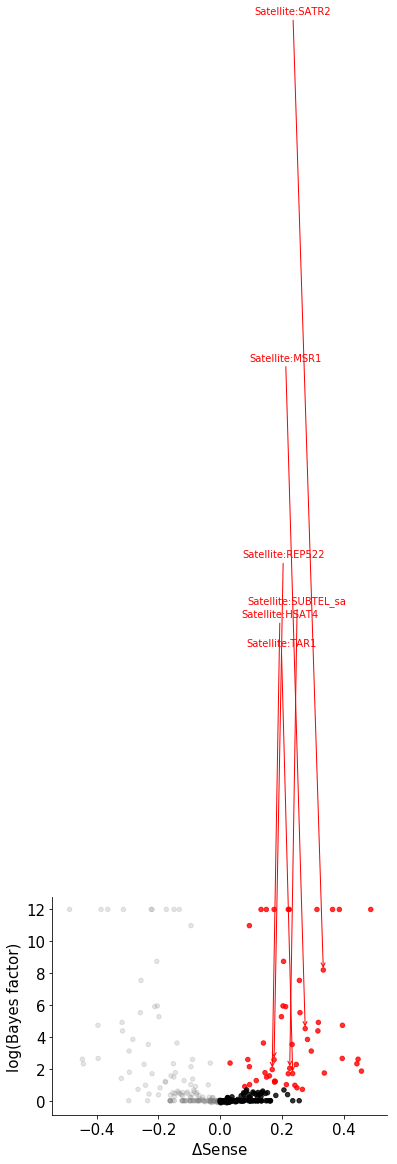

In [122]:
fig = plt.figure()
epsilon = 1e-12
x_val = 'delta_sense'
ax = fig.add_subplot(111)
plot_bf_df = posterior_df\
    .query('bayes_factor > 0') \
    .assign(log_bf = lambda d: d.bayes_factor.transform(lambda x: np.log10(x)))\
    .assign(label = lambda d: np.where(d[x_val] < 0, 'Antisense','Sense')) \
    .assign(color = lambda d: np.where(d.label == "Antisense", 'gray', 'black'))\
    .assign(color = lambda d: np.where((d.label != "Antisense") & (d.bayes_factor > 5), 'red', d.color))
    
for lab, lab_df in  plot_bf_df.groupby('label'):
    if lab == "Sense":
        alpha = 0.8
        color = 'black' 
        
        data = []
        text = []
        colors = []
        for i, row in lab_df.iterrows():
            x = row[x_val]
            y = row['log_bf']
            data.append((x,y))
            if row['bayes_factor'] > 2 and re.search('telo|Sat|cen', row['gene_id']):
                text.append(row['gene_name'])
            else:
                text.append('')
            colors.append(row['color'])
        spring_layout(ax, data, text, colors = colors)
    else:
        alpha = 0.2
        color = 'gray'
    
    lab_df.plot.scatter(x_val,'log_bf', 
                        ax = ax, 
                        color = lab_df.color, 
                        alpha=alpha )
plt.axvline(x = 0, linestyle=':', alpha=0.01, color='gray')
sns.despine()
ax.set_ylabel('log(Bayes factor)')
ax.set_xlabel('$\Delta$Sense')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


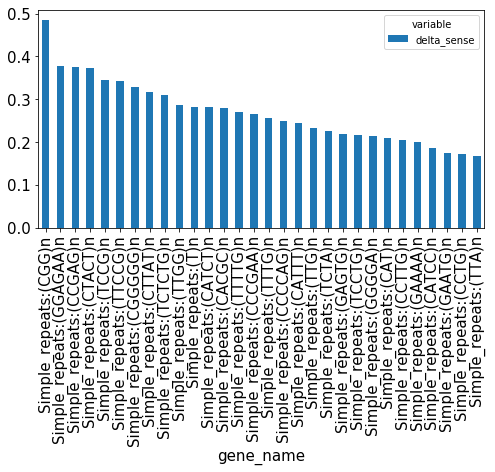

In [34]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
plot_bf_df\
    .query('bayes_factor>5 & pval < 0.05')\
    .set_index('gene_name')\
    .filter(['delta_sense'])\
    .nlargest(30, 'delta_sense')\
    .plot.bar(ax=ax)

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Density')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


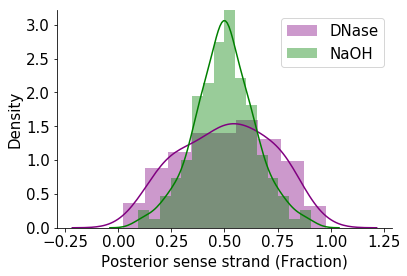

In [132]:
ax = plt.subplot(111)
sns.distplot(dnase_posterior_df.posterior, label = 'DNase', color = 'purple')
sns.distplot(naoh_posterior_df.posterior, label = 'NaOH', color = 'green')
ax.set_xlabel('Posterior sense strand (Fraction)')
sns.despine()
ax.legend(fontsize=15)
ax.set_ylabel('Density')

In [57]:
dnase_posterior_df.pipe(lambda d: d[d.bayes_factor==d.bayes_factor.max()])

,sense,antisense,gene_id,gene_name,posterior,alpha1,beta1,bayes_factor
43,2,0,Simple_repeats,Simple_repeats:(CAGAT)n,0.602539,5.902271,3.893388,0.278993
61,2,0,Simple_repeats,Simple_repeats:(CATTA)n,0.602539,5.902271,3.893388,0.278993
81,2,0,Simple_repeats,Simple_repeats:(CCTCG)n,0.602539,5.902271,3.893388,0.278993
134,2,0,Simple_repeats,Simple_repeats:(GTTTG)n,0.602539,5.902271,3.893388,0.278993
145,2,0,Simple_repeats,Simple_repeats:(TAGTG)n,0.602539,5.902271,3.893388,0.278993
150,2,0,Simple_repeats,Simple_repeats:(TATTG)n,0.602539,5.902271,3.893388,0.278993
175,2,0,Simple_repeats,Simple_repeats:(TTAGG)n,0.602539,5.902271,3.893388,0.278993
187,2,0,Simple_repeats,Simple_repeats:(TTCTG)n,0.602539,5.902271,3.893388,0.278993
193,2,0,Simple_repeats,Simple_repeats:(TTTAA)n,0.602539,5.902271,3.893388,0.278993


variable,gene_name,gene_id,DNase: alpha1,DNase: antisense,DNase: beta1,DNase: posterior,DNase: sense,NaOH: alpha1,NaOH: antisense,NaOH: beta1,NaOH: posterior,NaOH: sense
0,Simple_repeats:(A)n,Simple_repeats,5.902271,19,22.893388,0.204971,2,384.902271,372,375.893388,0.505921,381
1,Simple_repeats:(AAATG)n,Simple_repeats,19.902271,22,25.893388,0.434589,16,598.902271,310,313.893388,0.656119,595
2,Simple_repeats:(AACTG)n,Simple_repeats,0.000000,0,0.000000,0.000000,0,7.902271,2,5.893388,0.572809,4
3,Simple_repeats:(AAGTG)n,Simple_repeats,9.902271,0,3.893388,0.717782,6,20.902271,9,12.893388,0.618490,17
4,Simple_repeats:(AATAG)n,Simple_repeats,15.902271,6,9.893388,0.616471,12,108.902271,97,100.893388,0.519087,105


In [35]:
cal_bayes_factor(19,100, 5.9, 22.89, 384.9, 375.89)

1.5486645170596728e+84

In [8]:
posterior_df.columns

Index(['treatment', 'gene_name', 'gene_id', 'DNase: antisense',
       'DNase: posterior', 'DNase: sense', 'NaOH: antisense',
       'NaOH: posterior', 'NaOH: sense'],
      dtype='object', name='variable')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


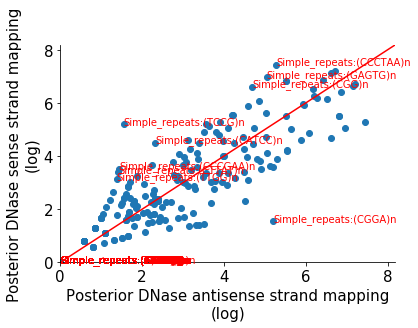

In [37]:
posterior_df['total'] =  posterior_df['DNase: antisense'] + posterior_df['DNase: sense']
posterior_df['x'] = np.log((1 - posterior_df['DNase: posterior']) * (posterior_df.total) + 1)
posterior_df['y'] = np.log(posterior_df['DNase: posterior'] * posterior_df['total'] + 1)

ax = plt.subplot(111)
ax.scatter(posterior_df['x'],posterior_df['y'])
ax.plot([0,20],[0,20], color = 'red')
ax.set_ylabel('Posterior DNase sense strand mapping\n(log)')
ax.set_xlabel('Posterior DNase antisense strand mapping\n(log)')
ax.set_xlim(0,posterior_df['x'].max() * 1.1)
ax.set_ylim(0,posterior_df['y'].max() * 1.1)
#ax.set_xlim(0,1)
#ax.set_ylim(0,1)
sns.despine()

for i, row in posterior_df.iterrows():
    if  ( row['DNase: posterior'] > 0.85 or row['DNase: posterior'] < 0.05):
        ax.text(row['x'],row['y'],
               row['gene_name'], color='red',ha='left')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


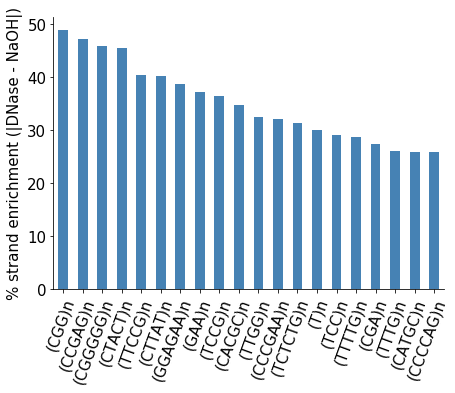

In [38]:
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111)
top_n = 20
plot_df = posterior_df\
    .assign(naoh_posterior = lambda d: np.where(d['NaOH: posterior'] > 0, d['NaOH: posterior'], 0.5))\
    .pipe(lambda d: d[d['DNase: posterior'] > 0])\
    .pipe(lambda d: d[~((d.gene_id.str.contains('Simple')) & (d['DNase: posterior'] < 0.5))])\
    .assign(new_posterior = lambda d: np.abs(d['DNase: posterior'] - d['naoh_posterior']) * 100)\
    .nlargest(top_n, 'new_posterior')\
    .set_index('gene_name')
colors = np.where(plot_df['DNase: posterior'].astype(float) < 0.5,'salmon','steelblue')
plot_df\
    .reset_index()\
    .plot\
    .bar('gene_name','new_posterior', ax=ax, color = colors.tolist())
ax.set_ylabel(r'% strand enrichment (|DNase - NaOH|)')
ax.set_xlabel('')
ax.legend().set_visible(False)
xt = ax.set_xticklabels([x.get_text().split(':')[1] for x in ax.get_xticklabels()], 
                        rotation = 70, 
                        ha='right', rotation_mode='anchor')
sns.despine()

pat = [mpatches.Patch(color=col, label=lab) for col, lab in zip(['steelblue','salmon'], 
                                                                ['Sense','Antisense'])]
#lgd = ax.legend(handles=pat, bbox_to_anchor = (1,0.5), 
#          title='Strand\nenrichment', fontsize=15,
#         frameon=False)
#lgd =plt.setp(lgd.get_title(),fontsize=15)

Text(0,0.5,'Strand specificity (%)\nAntisense --> Sense')

/stor/work/Lambowitz/cdw2854/src/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


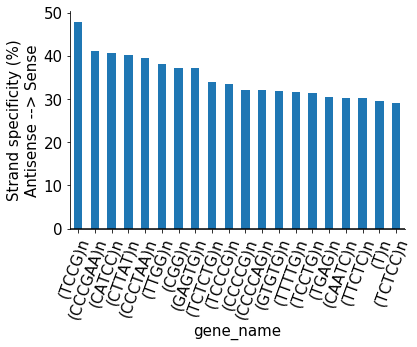

In [44]:
ax = plt.subplot()
dnase_posterior_df\
    .assign(diff = lambda d: 100*(d.posterior -  naoh_alpha0/(naoh_alpha0 + naoh_beta0)))\
    .assign(abs_diff = lambda d: np.abs(d['diff'])) \
    .pipe(lambda d: d[~((d['diff'] < 0) & (d.gene_name.str.contains('Simple')))])\
    .nlargest(20,'abs_diff') \
    .set_index('gene_name')\
    .filter(['diff']) \
    .sort_values('diff', ascending=False) \
    .plot.bar(ax = ax)
sns.despine()
ax.legend().set_visible(False)
ax.hlines(y=0, xmin=-1,xmax=21)
xt = ax.set_xticklabels([x.get_text().split(':')[1] for x in ax.get_xticklabels()], 
                        rotation = 70, 
                        ha='right', rotation_mode='anchor')
ax.set_ylabel('Strand specificity (%)\nAntisense --> Sense')

In [45]:
from scipy.stats import binom
from scipy import log, exp
from scipy.special import betaln

N = 104490000
s = 52263471

# sf is the survival function, i.e. complementary cdf
# ccdf multiplied by 2 because we're doing a two-sided test
print("p-value: ", 2*binom.sf(s, N, 0.5))

# Compute the log of the Bayes factor to avoid underflow.
logbf = N*log(0.5) - betaln(s+0.5, N-s+0.5) + betaln(0.5, 0.5)
print("Bayes factor: ", exp(logbf))

p-value:  0.0003014446868283761
Bayes factor:  18.685499669356375
